##Transfer Learning with CNNs

In [1]:
#import necessary modules
import os
import random
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR



###PUBLIC VARIABLES

In [6]:
#number of images that will be used from each class
num_images_per_class = 70
#number of train images that will be used from each class
num_train_per_class = 50
#number of validation images that will be used from each class
num_val_per_class = 10

img_size = 224
batch_size = 8
num_classes = 8
learning_rate = 0.0001
num_epoch = 30

###LOAD DATA

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#the dataset path in  Google Drive
root_dir = "/content/drive/MyDrive/Micro_Organism"

Mounted at /content/drive


In [4]:
#create directories for train, validation, test data
os.makedirs("train")
os.makedirs("validation")
os.makedirs("test")

In [5]:
# Get the sorted list of classes (subdirectories) in the root directory
classes = sorted(os.listdir(root_dir))
num_images_per_folder = 70
# Iterate over each class
for dir_name in classes:
    #get path to images
    images_dir = os.path.join(root_dir, dir_name)
    #get images names
    filenames = os.listdir(images_dir)
    random.seed(42)
    #shuffle images
    random.shuffle(filenames)

    # Create paths for train, validation, and test sets
    train_path = os.path.join('train', dir_name)
    val_path = os.path.join('validation', dir_name)
    test_path = os.path.join('test', dir_name)

    if not os.path.exists(train_path):
        os.makedirs(train_path)
        os.makedirs(val_path)
        os.makedirs(test_path)

    # Copy images to the respective train, validation, and test directories
    for i in range(num_images_per_folder):
        filename = filenames[i]
        filepath = os.path.join(images_dir, filename)
        #copy first 50 images to train set
        if (i < 50):
          shutil.copy(filepath, train_path)
        #copy next 10 images to validation set
        elif ( i < 60 ):
          shutil.copy(filepath, val_path)
        #copy final 10 images to test set
        else:
          shutil.copy(filepath, test_path)



In [7]:
# Define  transformations to be applied to the images
all_transforms = transforms.Compose([transforms.Resize((img_size ,img_size )),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

# Create the train,validation,test set with the given transformations
trainset = datasets.ImageFolder(root="train", transform=all_transforms)
valset = datasets.ImageFolder(root="validation", transform=all_transforms)
testset = datasets.ImageFolder(root="test", transform=all_transforms)

In [8]:
# Create data loaders for the train, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

###RES-NET18 MODEL

In [9]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# freeze all layers except the last FC layer
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 8)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

###TRAIN & VALIDATE

In [11]:
def train_one_epoch(model):
  running_loss = 0.
  running_acc = 0
  last_loss = 0
  last_acc = 0
  for i, data in enumerate(trainloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Zero your gradients for every batch!
    optimizer.zero_grad()
    # Make predictions for this batch
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    loss.backward()
    # Adjust learning weights
    optimizer.step()
    # Gather data and report
    running_loss += loss.item()
    acc =  ((predicted == labels).sum().item() / num_classes) * 100
    running_acc += acc
    if i % batch_size ==  batch_size-1:
      last_loss = running_loss / batch_size  # loss per batch
      last_acc = (running_acc / batch_size) # acc per batch
      print('batch {} loss: {} acc: {} % '.format(i + 1, last_loss, last_acc))
      running_loss = 0.
      running_acc = 0.

  return last_loss, last_acc

def train_val(model):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        best_models = []
        best_models_path = []
        best_vacc= 0
        model.to(device)
        for epoch in range(num_epoch):
            print("EPOCH:  " ,epoch)
            model.train(True)
            avg_loss , avg_acc = train_one_epoch(model)

            running_vloss = 0.0
            running_vacc = 0.0
            model.eval()


            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for i, vdata in enumerate(validationloader):
                    vinputs, vlabels = vdata
                    vinputs = vinputs.to(device)
                    vlabels = vlabels.to(device)
                    voutputs = model(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    running_vloss += vloss.item()

                    _, vpredicted = torch.max(voutputs.data, 1)
                    vacc =  ((vpredicted == vlabels).sum().item() / num_classes) * 100
                    running_vloss += vloss.item()
                    running_vacc += vacc


            avg_vloss = running_vloss / (i + 1)
            avg_vacc = running_vacc / (i + 1)

            train_loss.append(avg_loss)
            train_acc.append(avg_acc)
            val_loss.append(avg_vloss)
            val_acc.append(avg_vacc)
            print('LOSS train {:.3f} valid {}'.format(avg_loss, avg_vloss))
            print("avg loss " , avg_vloss)
            if avg_vacc > best_vacc:
                best_vacc = avg_vacc
                #model_path = 'model_{:.3f}_{}'.format(best_vloss, epoch)
                best_models.append(model)
                #best_models_path.append(model_path)

        #torch.save(best_models[-1].state_dict(), best_models_path[-1])
        return train_loss, train_acc, val_loss , val_acc , best_models[-1]


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)



train_loss, train_acc, val_loss, val_acc, best_model = train_val(model)

EPOCH:   0
batch 8 loss: 2.462013363838196 acc: 10.9375 % 
batch 16 loss: 2.1898592114448547 acc: 18.75 % 
batch 24 loss: 2.271670714020729 acc: 14.0625 % 
batch 32 loss: 2.150719106197357 acc: 18.75 % 
batch 40 loss: 2.1617210507392883 acc: 17.1875 % 
batch 48 loss: 2.1626975685358047 acc: 7.8125 % 
LOSS train 2.163 valid 4.342635297775269
avg loss  4.342635297775269
EPOCH:   1
batch 8 loss: 2.0033775120973587 acc: 15.625 % 
batch 16 loss: 2.1160880625247955 acc: 12.5 % 
batch 24 loss: 2.0783272981643677 acc: 23.4375 % 
batch 32 loss: 2.0883347392082214 acc: 15.625 % 
batch 40 loss: 2.0947217643260956 acc: 12.5 % 
batch 48 loss: 1.9989029318094254 acc: 17.1875 % 
LOSS train 1.999 valid 4.177090716362
avg loss  4.177090716362
EPOCH:   2
batch 8 loss: 2.0194744020700455 acc: 21.875 % 
batch 16 loss: 1.8955931961536407 acc: 28.125 % 
batch 24 loss: 1.894225850701332 acc: 31.25 % 
batch 32 loss: 1.9293093532323837 acc: 21.875 % 
batch 40 loss: 2.0422987788915634 acc: 26.5625 % 
batch 48 l

In [13]:
max(val_acc)

55.0

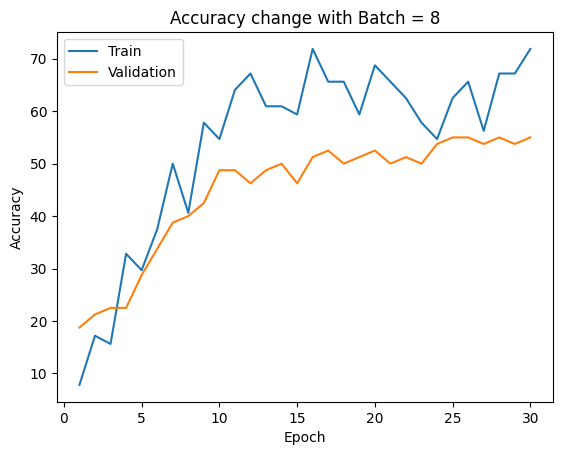

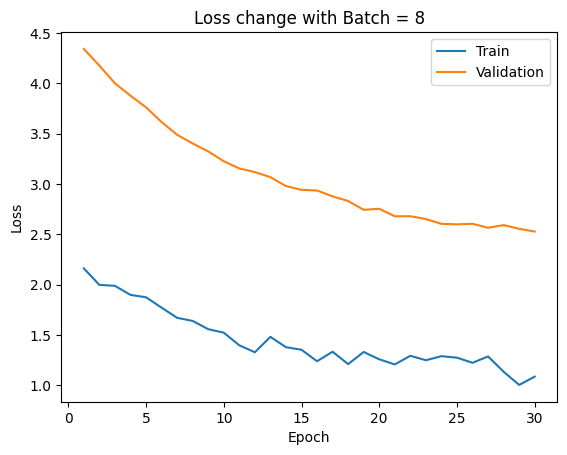

In [14]:
#PLOT LOSS AND ACCURACY CHANGE OF TRAIN AND VALIDATION SET
def plot(list1,list2,title,name,type):
  plt.plot(range(1,num_epoch+1),list1,  label = "Train")
  plt.plot(range(1,num_epoch+1),list2, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel(type)
  plt.title(title)
  plt.legend()
  filename = f"{name}.png"
  plt.savefig(filename)
  plt.show()

plot(train_acc,val_acc,"Accuracy change with Batch = 8","Accuracy_b_8","Accuracy")
plot(train_loss,val_loss,"Loss change with Batch = 8","Loss_b_8","Loss")

###TEST USING BEST MODEL

In [15]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()


            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(target.tolist())

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Test set: Average loss: {:.3f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # return average loss for the epoch

    return avg_loss, true_labels, predicted_labels

avg_loss, true_labels, predicted_labels = test(best_model, device, testloader)

Validation set: Average loss: 1.345, Accuracy: 43/80 (53.8%)



In [16]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



def confusion(true_labels, predicted_labels):
  cm = confusion_matrix(true_labels, predicted_labels)
  cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
  plt.figure(figsize=(5,4))

  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()


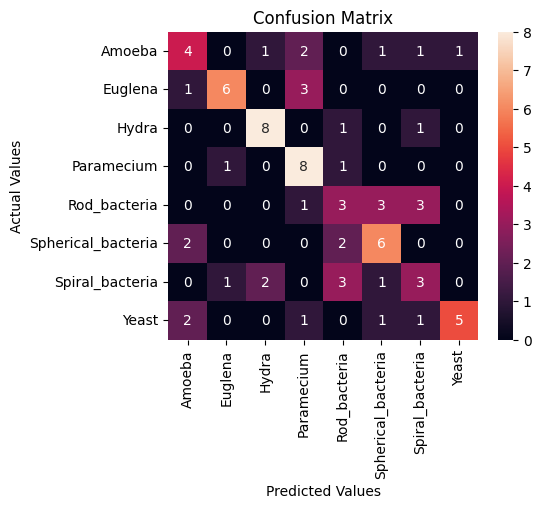

In [17]:
confusion(true_labels, predicted_labels)

##PART 2.2

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Freeze layers up to the second-to-last convolutional layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two convolutional layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

# Modify the FC layer
num_classes = 8
model.fc = nn.Linear(model.fc.in_features, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [
        {"params": model.layer4.parameters()},
        {"params": model.layer3.parameters()},
        {"params": model.fc.parameters()},
    ],
    lr=0.0001,
    momentum=0.9,
)


In [18]:
#TRAINING - VALIDATION
train_loss, train_acc, val_loss, val_acc, best_model = train_val(model)

EPOCH:   0
batch 8 loss: 1.1271340101957321 acc: 65.625 % 
batch 16 loss: 1.1592981740832329 acc: 65.625 % 
batch 24 loss: 1.0900954455137253 acc: 68.75 % 
batch 32 loss: 1.163564994931221 acc: 62.5 % 
batch 40 loss: 1.1014495939016342 acc: 65.625 % 
batch 48 loss: 1.0289713740348816 acc: 67.1875 % 
LOSS train 1.029 valid 2.4975629687309264
avg loss  2.4975629687309264
EPOCH:   1
batch 8 loss: 1.10525082051754 acc: 68.75 % 
batch 16 loss: 1.0283756256103516 acc: 71.875 % 
batch 24 loss: 1.0847142338752747 acc: 70.3125 % 
batch 32 loss: 1.164181798696518 acc: 59.375 % 
batch 40 loss: 1.0145838856697083 acc: 75.0 % 
batch 48 loss: 1.0350156798958778 acc: 76.5625 % 
LOSS train 1.035 valid 2.5097560405731203
avg loss  2.5097560405731203
EPOCH:   2
batch 8 loss: 1.1231400072574615 acc: 68.75 % 
batch 16 loss: 1.119652882218361 acc: 67.1875 % 
batch 24 loss: 1.065102830529213 acc: 76.5625 % 
batch 32 loss: 1.0610743463039398 acc: 64.0625 % 
batch 40 loss: 0.9976982325315475 acc: 73.4375 % 
b

In [19]:
max(val_acc)

60.0

In [21]:
avg_loss, true_labels, predicted_labels = test(best_model, device, testloader)

Validation set: Average loss: 1.245, Accuracy: 44/80 (55.0%)



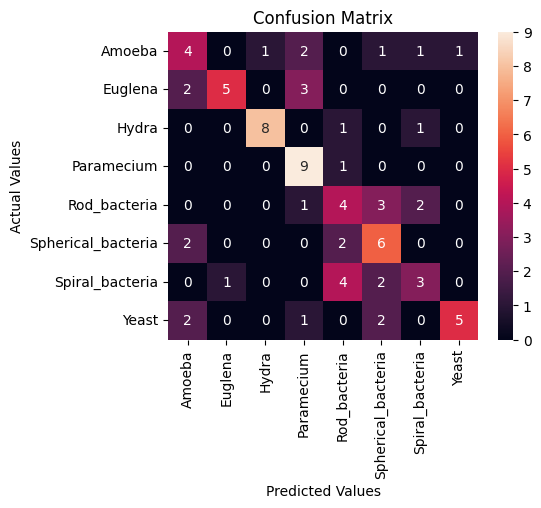

In [22]:
confusion(true_labels, predicted_labels)